# Mesa ABM of the Keep Threshold Relay

### Simulation notes and instructions

Notes:
* Nodes are created simulataneously using the Mesa SimultaneousActivation scheduler
* The nodes go through a bootstrap phase based on Antonio's diagram. They can only form groups if they are in the mainloop forked state.
* Relay requests are currently bernoulli trials
* Each step could be assumed to be a block
* Singature events are modeled by default as asynchronous with a step delay to mimick the block delay
* We assume that 1 node = 1 staker

Instructions:
1. Change variables
2. Click on the restart and run kernel icon for ipython


In [1]:
import random
import datetime
import numpy as np
import pandas as pd
import agent
import model
import matplotlib.pyplot as plt

**Initialize Variables**

The following variables determine how the simulation will perform. Each variable has a comment beside it describing what it means. We suggest you change individual variables one at a time and run the simulation each time to see how they impact the simulation.

In [2]:
# Group & Signature Parameters
group_size = 100 # number of virtual stakers in a group - nodes to stakers is a 1-many relationship
nodes = 100 # total number of nodes (assume 1 node = 1 staker)
active_group_threshold =10 # number of active groups to bootstrap at start
min_nodes = 40 # min number of nodes that must be online so as to increase the likelihood of lower max ownership
max_malicious_threshold = 20 # % of malicious node ownership needed to sign
signature_delay = 2 # lambda for poisson distribution used to generate a delay before the signature is executed
group_expiry = 14 # number of steps after which a group expires
Misbehaving_nodes = 10 # percent of nodes misbehaving during dkg
dkg_block_delay = 14 # blocks needed to run DKG
compromised_threshold = 0.3 # malicious + offline > threshold = compromised
failed_signature_threshold = 0.6 # % of offline nodes causing a signature to fail

#Node parameters
node_failure_percent = 10 # % of times nodes fail and have to reconnect
node_death_percent = 5 # % of time nodes fail and do not reconnect
node_connection_delay = 5 # max delay for a node to connect or reconnect after failure
node_mainloop_connection_delay = 3 # max delay for a node to fork or refork mainloop after failure

#Model Parameters
log_filename = 'master_sim.log'
run_number = 0
steps = 1000 #blocks

**Creating the virtual staker distributions**

The code below assignes virtual stakers to each node based on the specified distribution. The default is a linear distribution. In the current simulation, virtual stakers also represent tickets for group selection. During group selection, each node produces a number of tickets proportional to the number of virtual stakers. These tickets then help determine participation in a group. The more tickets a node has the more likely it is that a node's virtual stakers will be represented in the group.

Text(0.5, 1.0, 'Virtual Staker Cumulative Distribution')

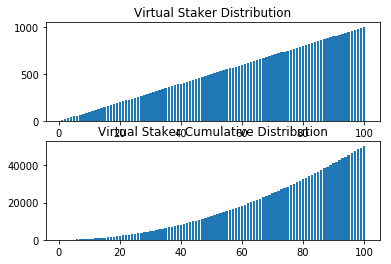

In [3]:
# Pre-processing Staker distributions
# Linear y = m * (x + 1) since indices start from 0
ticket_distribution = np.zeros(nodes) 

for i in range (0, nodes):
    ticket_distribution[i] =  10 * (i + 1) # m = 50 gives max y as 1000 which is 2% of 50000

x = np.linspace(1,nodes,nodes)
plt.subplot(2, 1, 1)
plt.bar(x, ticket_distribution)
plt.title("Virtual Staker Distribution")

cdf_L02=model.create_cdf(nodes,ticket_distribution)
plt.subplot(2, 1, 2)
plt.bar(x, cdf_L02)
plt.title("Virtual Staker Cumulative Distribution")

**Initialize the model**

Intializing the model and agents

In [4]:
beacon_model = model.Beacon_Model(nodes, ticket_distribution, 
                                  active_group_threshold, 
                                  group_size, 
                                  max_malicious_threshold, 
                                  group_expiry, 
                                  node_failure_percent, 
                                  node_death_percent, 
                                  signature_delay,
                                  min_nodes,
                                  node_connection_delay,
                                  node_mainloop_connection_delay,
                                  log_filename,
                                  run_number,
                                  Misbehaving_nodes,
                                  dkg_block_delay,
                                  compromised_threshold,
                                  failed_signature_threshold
                                 )


creating nodes


**Stepping throgh the model**

The model steps through and changes the state of each agent at each step. The MESA data collector collects data on agent and model state at each step.

In [5]:
active_group_size = []
signature_failures = []
for i in range (steps):
    beacon_model.step()

model_data = beacon_model.datacollector.get_model_vars_dataframe() 
agent_data = beacon_model.datacollector.get_agent_vars_dataframe()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


**Number of Active Groups**

The plot below shows a histogram of the number of active groups available at each step. Active groups increase due to the registration of new groups, which occurs when a relay entry is requested. Active groups remain active for the number of steps set by the group_expiry parameter. 

Text(0, 0.5, 'frequency')

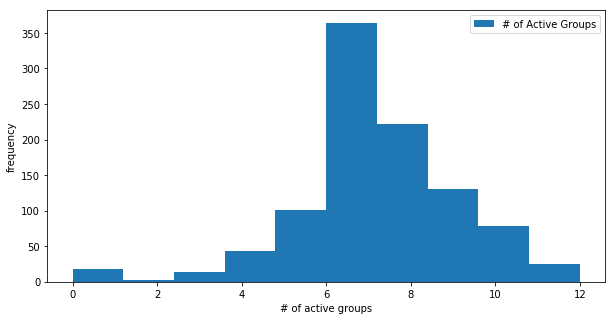

In [15]:
model_data.plot(kind='hist', legend = True, y = ['# of Active Groups'], figsize = (10,5))
plt.xlabel("# of active groups")
plt.ylabel("frequency")

**Active Groups, Node, and Signatures**

Active Groups: Active groups available at every step. Same as above active groups are created when a relay entry occurs and a group is successfully registered

Active Nodes: Active nodes are nodes in the staked status. This is based on the node state diagram provided by Antonio

Number of Signatures: Signatures completed in aggregate including those considered to have failed based on the number of offline nodes.

<function matplotlib.pyplot.show(*args, **kw)>

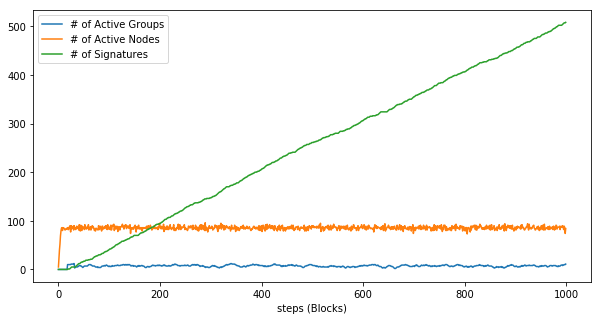

In [18]:
model_data.plot(kind='line', legend = True, y = ['# of Active Groups', '# of Active Nodes', '# of Signatures' ], figsize = (10,5))
plt.xlabel("steps (Blocks)")
plt.show


**Median Malicious, Dominator, & Failure %**

Median Malicious Group % : We take the poppulation of groups and calculate median malicious ownership of the groups from the malicious % property of the group agent. The malicious ownership % is the percentage of the groups virtual stakers owned by malicious nodes.

Median Dominator Group % : Similar to above we take the Dominator % property of each group and find the median at each step. The Dominator % = %owned by 1 node + Offline nodes

Median Failure % : Signature failures are determined by the offline % evaluated against the failed signature threshold set above. Signatures with % of nodes offline > than the threshold are considered to have failed. Once again we calculate the median at each step.

<function matplotlib.pyplot.show(*args, **kw)>

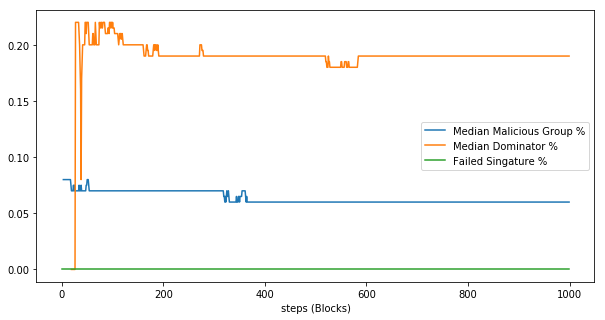

In [20]:
model_data.plot(kind='line', legend = True, y = ['Median Malicious Group %','Median Dominator %', 'Failed Singature %'], figsize = (10,5))
plt.xlabel("steps (Blocks)")
plt.show

**Compromised Groups & Dominated Signatures**

% Compromised Groups: % of total groups designated as compromised based on the compromised threshold set above

% Dominated signatures: % of signatures desiganted as dominated based on the max malicious threshold set above

<function matplotlib.pyplot.show(*args, **kw)>

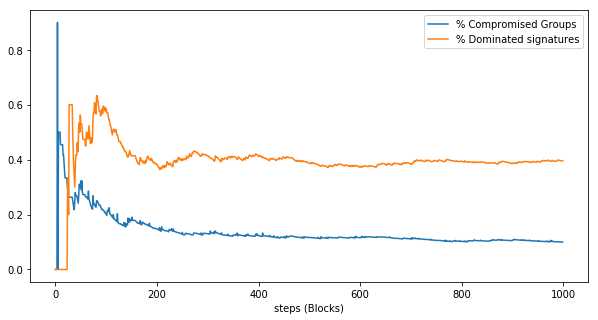

In [22]:
model_data.plot(kind='line', legend = True, y = ['% Compromised Groups','% Dominated signatures'], figsize = (10,5))
plt.xlabel("steps (Blocks)")
plt.show


<function matplotlib.pyplot.show(*args, **kw)>

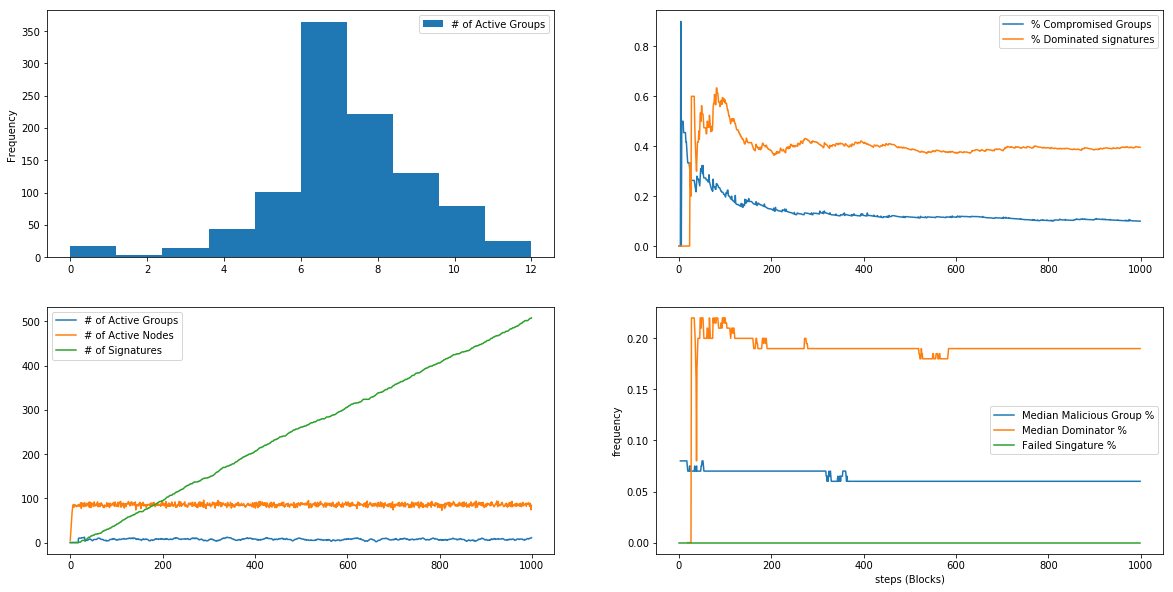

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (20,10))

#plt.figure(figsize = (10,10))
#plt.subplot(3, 1, 1)
model_data.plot(kind='hist', ax = axes[0,0], legend = True, y = ['# of Active Groups'])
plt.xlabel("# of active groups")
plt.ylabel("frequency")

model_data.plot(kind='line', ax = axes[1,0], legend = True, y = ['# of Active Groups', '# of Active Nodes', '# of Signatures' ])
plt.xlabel("steps (Blocks)")
plt.show

model_data.plot(kind='line', ax = axes[1,1], legend = True, y = ['Median Malicious Group %','Median Dominator %', 'Failed Singature %'], )
plt.xlabel("steps (Blocks)")
plt.show


model_data.plot(kind='line', ax = axes[0,1], legend = True, y = ['% Compromised Groups','% Dominated signatures'])
plt.xlabel("steps (Blocks)")
plt.show


* % of signatures dominated

In [7]:

data = agent_data[(agent_data['Type']=='group') & (agent_data['Type_ID']==3) ]
data

#data['Ownership Distribution'][3]


,,Type_ID,Type,Node Status (Connection_Mainloop_Stake),Status,Malicious,DKG Block Delay,Ownership Distribution,Malicious %,Offline %,Dominator %
Step,AgentID,,,,,,,,,,
4,103,3,group,None,dkg,None,13.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...",0.04,0.22,NaN
5,103,3,group,None,dkg,None,12.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...",0.04,0.18,NaN
6,103,3,group,None,dkg,None,11.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...",0.04,0.19,NaN
7,103,3,group,None,dkg,None,10.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...",0.04,0.19,NaN
8,103,3,group,None,dkg,None,9.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...",0.04,0.19,NaN
9,103,3,group,None,dkg,None,8.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...",0.04,0.19,NaN
10,103,3,group,None,dkg,None,7.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...",0.04,0.19,NaN
11,103,3,group,None,dkg,None,6.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...",0.04,0.19,NaN
12,103,3,group,None,dkg,None,5.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...",0.04,0.19,NaN


In [8]:
model_data

,# of Active Groups,# of Active Nodes,# of Signatures,Median Malicious Group %,% Compromised Groups,Median Dominator %,% Dominated signatures,Failed Singature %
0,0,5,0,NaN,0.000000,NaN,0.000000,0.0
1,0,22,0,NaN,0.000000,NaN,0.000000,0.0
2,0,40,0,NaN,0.000000,NaN,0.000000,0.0
3,0,52,0,0.080,0.000000,NaN,0.000000,0.0
4,0,69,0,0.080,0.900000,NaN,0.000000,0.0
5,0,79,0,0.080,0.000000,NaN,0.000000,0.0
6,0,85,0,0.080,0.500000,NaN,0.000000,0.0
7,0,86,0,0.080,0.500000,NaN,0.000000,0.0
8,0,80,0,0.080,0.500000,NaN,0.000000,0.0
9,0,86,0,0.080,0.500000,NaN,0.000000,0.0
